# Read data from numerical Simulation

The raw data are from the numerical Simulation by Seta and Federrath 2022 (https://ui.adsabs.harvard.edu/abs/2022MNRAS.514..957S/abstract)

# Install packages

In [1]:
# ! pip install astroML

In [2]:
# !pip install torch-lr-finder

In [ ]:
! pip install spectral-cube

# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/ML_HI/
!ls

In [6]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/ML_HI


# Paths

In [7]:
import sys, os
base_path = os.getcwd()

data_path  = os.path.join(base_path, 'data')
vae_path = os.path.join(base_path, 'vae')
seta_data_path = os.path.join(data_path, 'seta', '')

print(base_path)
print(data_path)

/content/gdrive/My Drive/Colab Notebooks/ML_HI
/content/gdrive/My Drive/Colab Notebooks/ML_HI/data


In [ ]:
training_data_file = 'Tb_mpism_comp_1200_thick.fits'
rhi_file = 'R_map_mpism_comp_1200.fits'
fcnm_file = 'fcnm_map_mpism_comp_1200_Tcut_500K.fits'

training_data_fits_file = os.path.join(seta_data_path, training_data_file)
training_fcnm_file = os.path.join(seta_data_path, fcnm_file)
training_rhi_file = os.path.join(seta_data_path, rhi_file)

print(training_data_fits_file)
print(training_fcnm_file)
print(training_rhi_file)

# Libraries

In [47]:
sys.path.insert(1, data_path)

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import ndimage

import glob
import pickle

In [10]:
from astropy.wcs import WCS
from spectral_cube import SpectralCube

# Read training dataset

Training set is a datacube with a size of (101, 512, 512) includes (512x512) spectra (spectral data: signal strength T_b as a function of 101 wavelength channels) and their ground-truth cold atomic hydrogen gas fraction (FCNM) and opacity correction factor (R). The training dataset was obtained from a simulation.

FCNM range: from ~0. to (less than) 1.
R range: >= 1

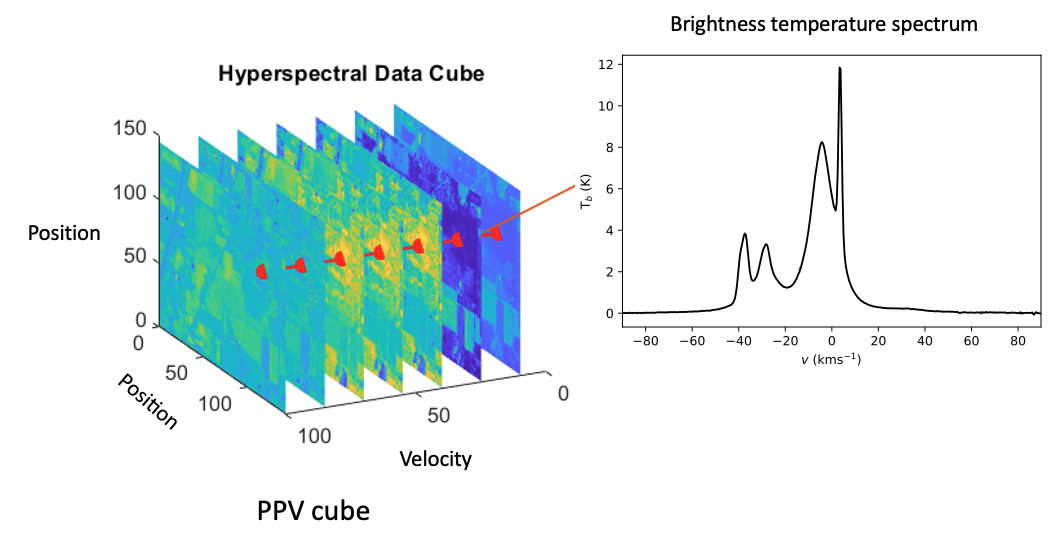

**Note:** Atomic Hydrogen Gas = HI

In [11]:
data, hdr = fits.getdata(training_data_fits_file, header=True)
print(data.shape)

(101, 512, 512)


Position X : 512 bins

Position Y : 512 bins

Velocity Z : 101 channels (in radio astronomy, wavelength [m]/frequency [Hz] is often converted into velocity [VLSR: km/s or m/s].)

In [12]:
# Velocity defined for the HI radiative transfer
vmin = -40 #km.s-1                                                               
vmax = 40 #km.s-1                                                                
dv = 0.8 #km.s-1

In [13]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
NAXIS3  =                  101                                                  
EXTEND  =                    T                                                  
CTYPE3  = 'v [km.s-1]'                                                          
CRVAL3  =   -8.000000000000114                                                  
CDELT3  =                  0.8                                                  
CRPIX3  =                   40                                                  
BUNIT   = 'K       '                                                            
COMMENT Tb                  

# Total intensity map (or optically-thin HI column density map)

Position-Position-Velocity (PPV) emission cubes with realistic noise (1K) and beam (30'') for a simulation located at 400pc.

In [14]:
WHI = np.sum(data, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI * dv # In unit of 10^20 cm-2

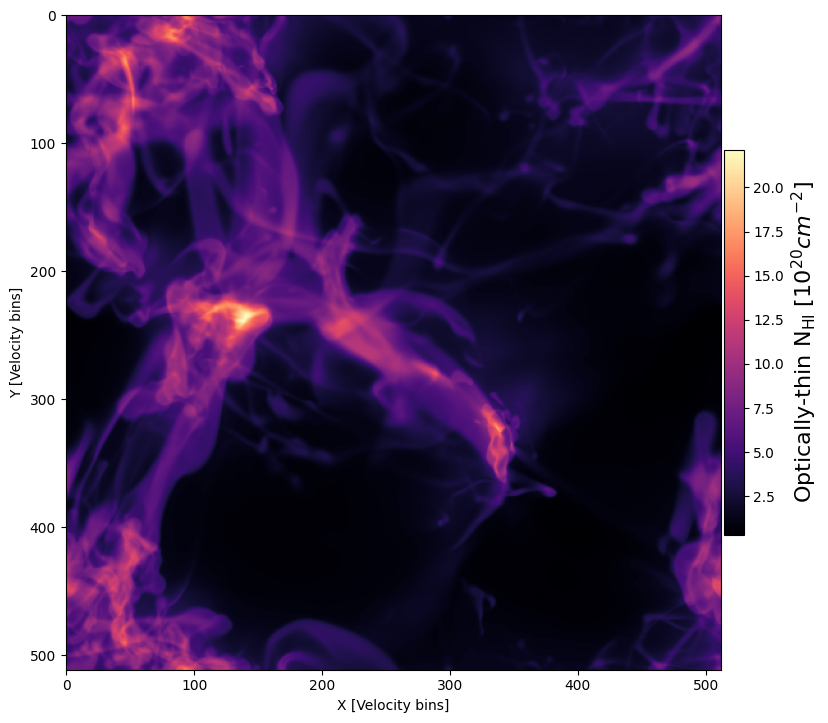

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(NHI_thin, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20} cm^{-2}$]', size=16)

plt.title('')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

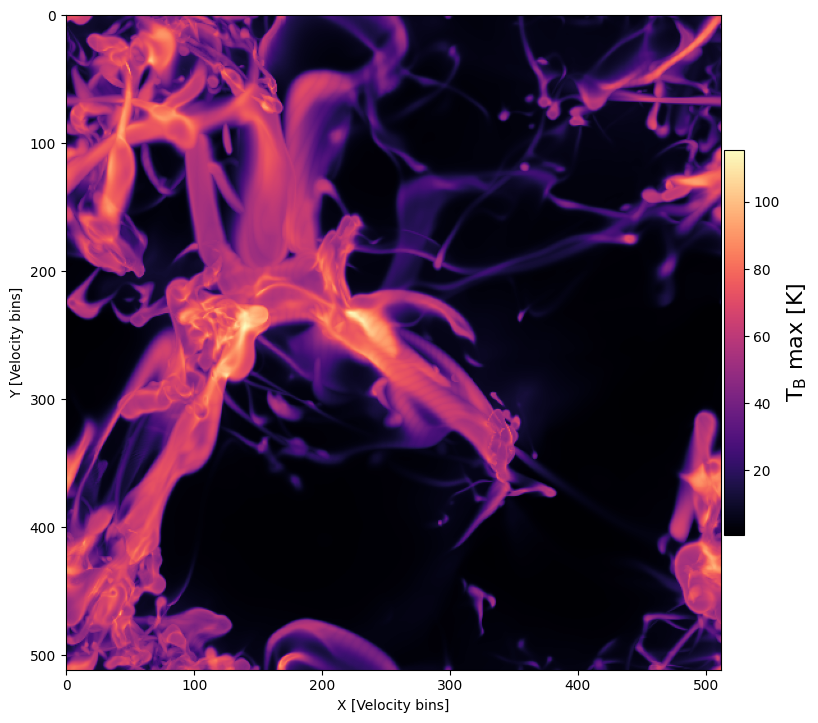

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(data, axis=0), cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('T$_\mathrm{B}$ max [K]', size=16)

plt.title('')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

# Ground-truth cold HI gas fraction

Each spectrum at (Xi, Yi) has a corresponding ground-truth $F_{CNM}$ at the same sky pixel (Xi, Yi).

In [53]:
fcnm_data, hdr = fits.getdata(training_fcnm_file, header=True)
print(fcnm_data.shape)

(512, 512)


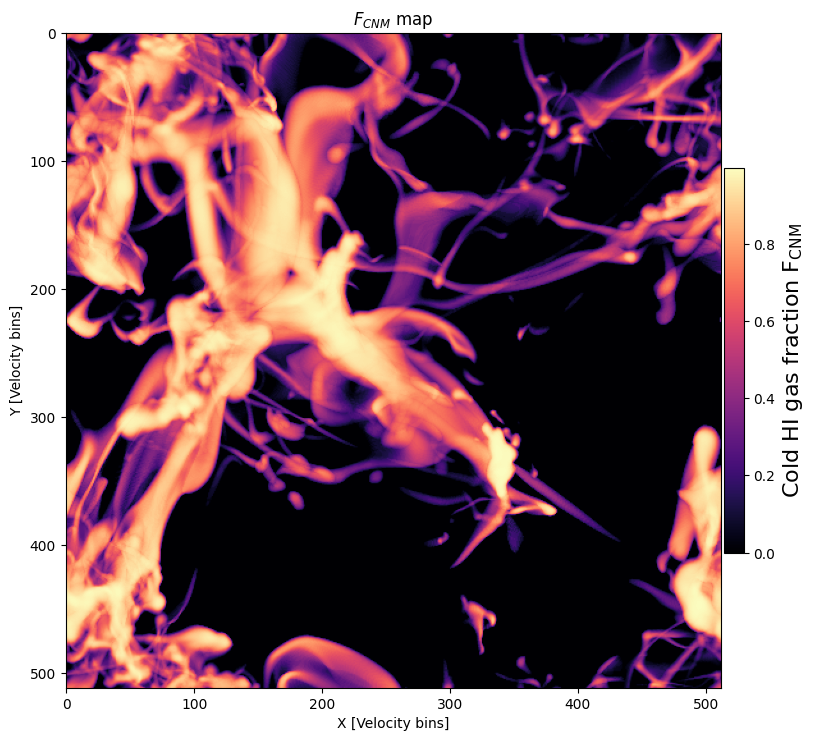

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(fcnm_data, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Cold HI gas fraction F$_\mathrm{CNM}$', size=16)

plt.title('$F_{CNM}$ map')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

In [55]:
# Noise level and beam size
noise = 1. #K
beam = 1.45 # pix - ASKAP at 400pc with Saury resolution

training_fcnm_outfile = 'fcnm_map_mpism_comp_1200_Tcut_500K' + '_noise_' + str(noise) + '_K_beam_' + str(beam) + '_pix.fits'
training_fcnm_fits_outfile = os.path.join(seta_data_path, training_fcnm_outfile)
print(training_fcnm_fits_outfile)

#Convolution beam cube
noise_fcnm_data = ndimage.gaussian_filter(fcnm_data, [beam, beam])

hdu0 = fits.PrimaryHDU(noise_fcnm_data, header=hdr)
hdulist = fits.HDUList([hdu0])
hdulist.writeto(training_fcnm_fits_outfile, overwrite=True)

/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/seta/fcnm_map_mpism_comp_1200_Tcut_500K_noise_1.0_K_beam_1.45_pix.fits


## Read smoothed data (with noise)

In [56]:
fcnm_noise_data, hdr = fits.getdata(training_fcnm_fits_outfile, header=True)
print(fcnm_noise_data.shape)

(512, 512)


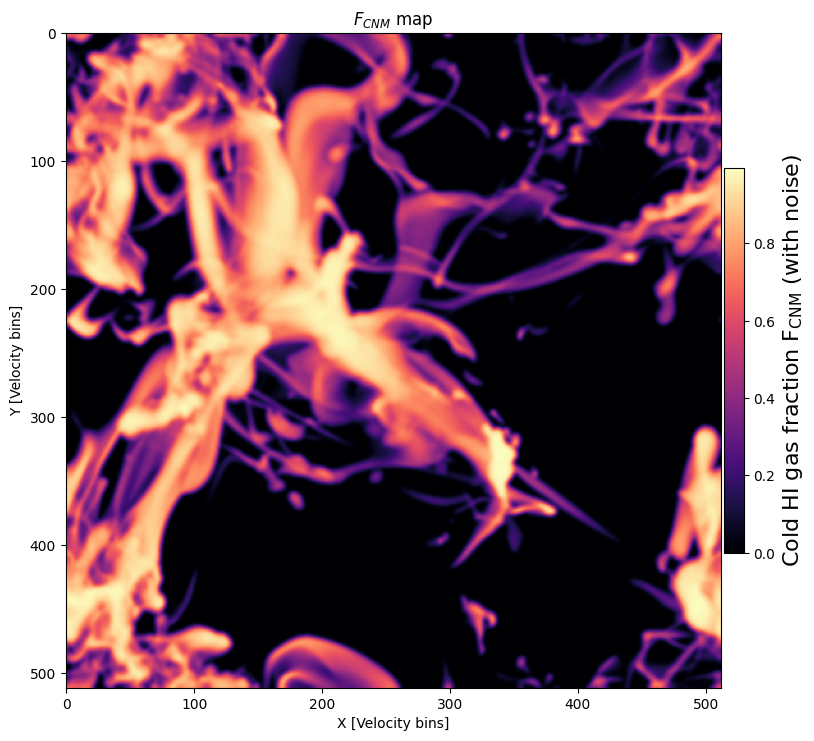

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(fcnm_noise_data, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Cold HI gas fraction F$_\mathrm{CNM}$ (with noise)', size=16)

plt.title('$F_{CNM}$ map')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

# Ground-truth opacity correction factor

Each spectrum at (Xi, Yi) has a corresponding ground-truth $R_{HI}$ at the same sky pixel (Xi, Yi).

In [61]:
rhi_data, hdr = fits.getdata(training_rhi_file, header=True)
print(rhi_data.shape)

(512, 512)


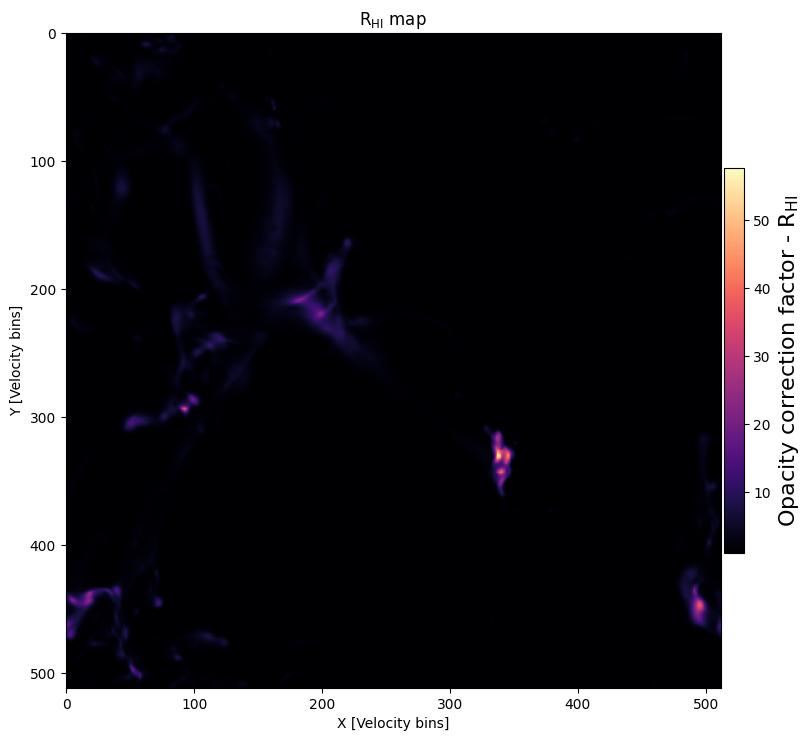

In [62]:
plt.figure(figsize=(10,10))
plt.imshow(rhi_data, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Opacity correction factor - R$_\mathrm{HI}$', size=16)

plt.title(r'R$_\mathrm{HI}$ map')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

In [63]:
# Noise level and beam size
noise = 1. #K
beam = 1.45 # pix - ASKAP at 400pc with Saury resolution

training_rhi_outfile = 'R_map_mpism_comp_1200' + '_noise_' + str(noise) + '_K_beam_' + str(beam) + '_pix.fits'
training_rhi_fits_outfile = os.path.join(seta_data_path, training_rhi_outfile)
print(training_rhi_fits_outfile)

#Convolution beam cube
noise_rhi_data = ndimage.gaussian_filter(rhi_data, [beam, beam])

hdu0 = fits.PrimaryHDU(noise_rhi_data, header=hdr)
hdulist = fits.HDUList([hdu0])
hdulist.writeto(training_rhi_fits_outfile, overwrite=True)

/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/seta/R_map_mpism_comp_1200_noise_1.0_K_beam_1.45_pix.fits


## Read smoothed data (with noise)

In [64]:
rhi_noise_data, hdr = fits.getdata(training_rhi_fits_outfile, header=True)
print(rhi_noise_data.shape)

(512, 512)


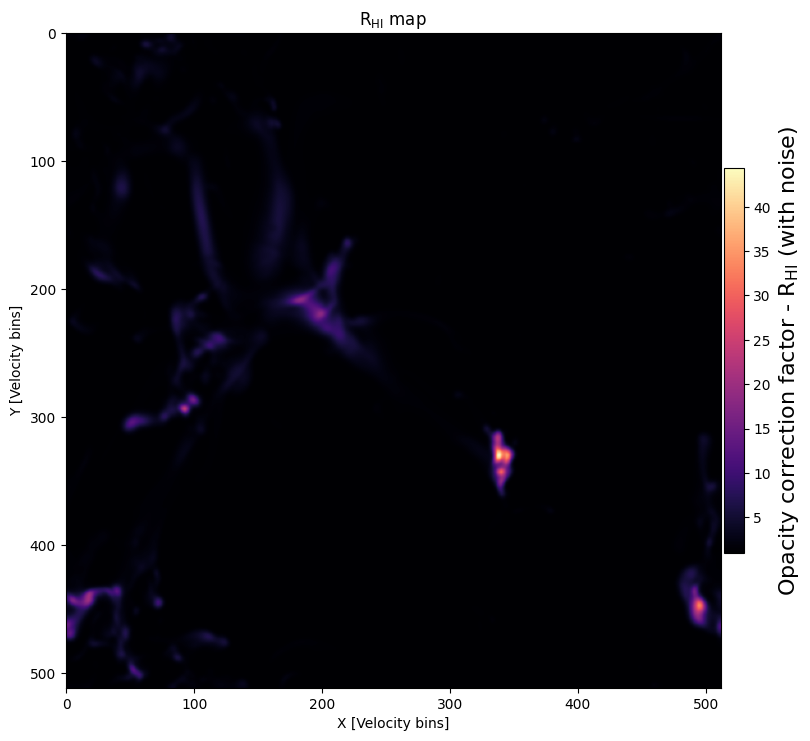

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(rhi_noise_data, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Opacity correction factor - R$_\mathrm{HI}$ (with noise)', size=16)

plt.title(r'R$_\mathrm{HI}$ map')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

# Plot a few spectra

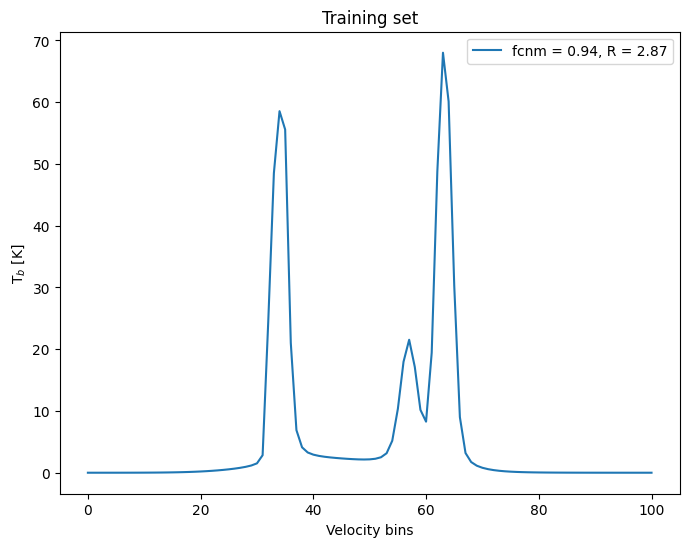

In [21]:
xid, yid = 100, 100
fcnm_val = fcnm_data[xid, yid]
rhi_val = rhi_data[xid, yid]

# Spectrum in training set
plt.figure(figsize=(8,6))
plt.plot(data[:, yid, xid], label='fcnm = %3.2f, R = %3.2f' % (fcnm_val, rhi_val))

plt.title('Training set')
plt.xlabel('Velocity bins')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

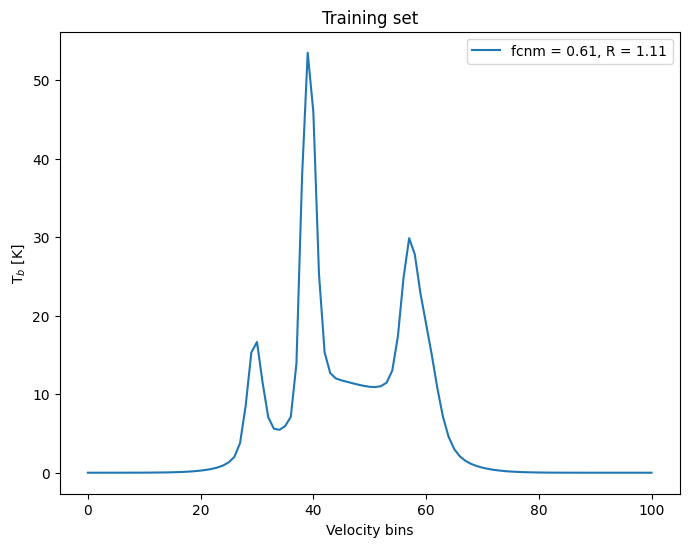

In [22]:
# Spectrum in training set
xid, yid = 100, 20
fcnm_val = fcnm_data[xid, yid]
rhi_val = rhi_data[xid, yid]

plt.figure(figsize=(8,6))
plt.plot(data[:, yid, xid], label='fcnm = %3.2f, R = %3.2f' % (fcnm_val, rhi_val))

plt.title('Training set')
plt.xlabel('Velocity bins')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

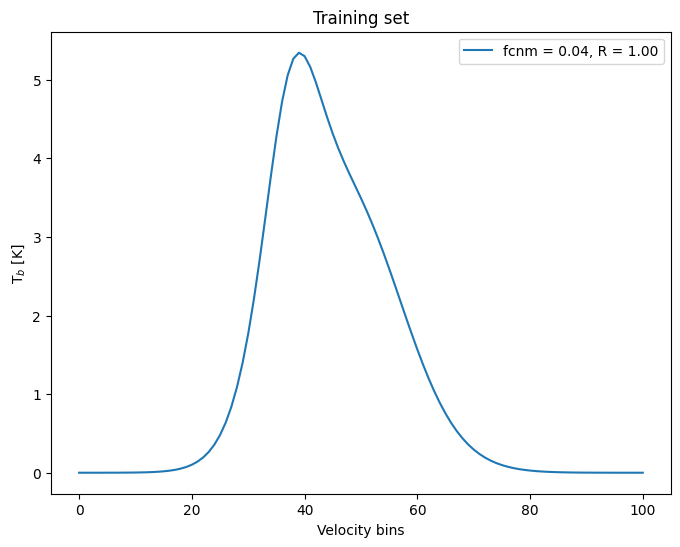

In [23]:
# Spectrum in training set
xid, yid = 200, 20
fcnm_val = fcnm_data[xid, yid]
rhi_val = rhi_data[xid, yid]

plt.figure(figsize=(8,6))
plt.plot(data[:, yid, xid], label='fcnm = %3.2f, R = %3.2f' % (fcnm_val, rhi_val))

plt.title('Training set')
plt.xlabel('Velocity bins')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

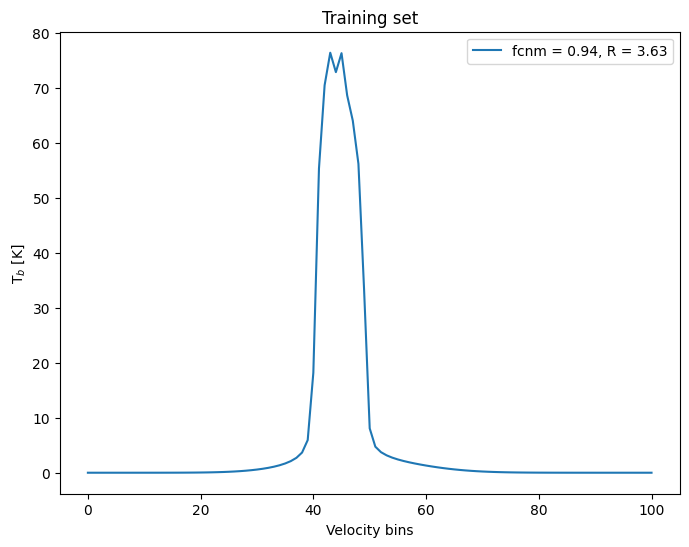

In [24]:
# Spectrum in training set
xid, yid = 200, 200
fcnm_val = fcnm_data[xid, yid]
rhi_val = rhi_data[xid, yid]

plt.figure(figsize=(8,6))
plt.plot(data[:, yid, xid], label='fcnm = %3.2f, R = %3.2f' % (fcnm_val, rhi_val))

plt.title('Training set')
plt.xlabel('Velocity bins')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

# Images along the wavelength channels

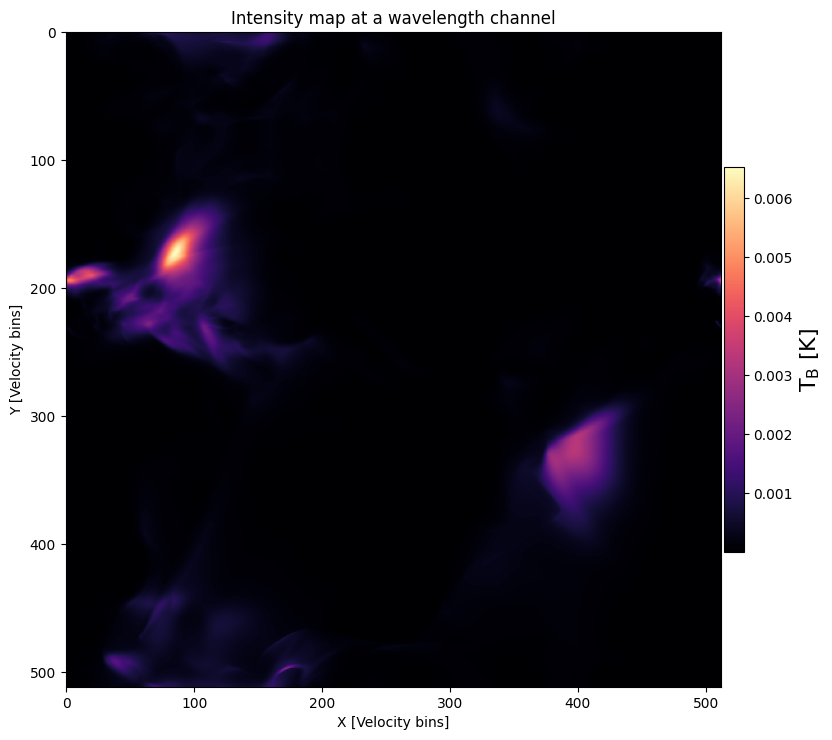

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(data[0, :, :], cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('T$_\mathrm{B}$ [K]', size=16)

plt.title('Intensity map at a wavelength channel')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

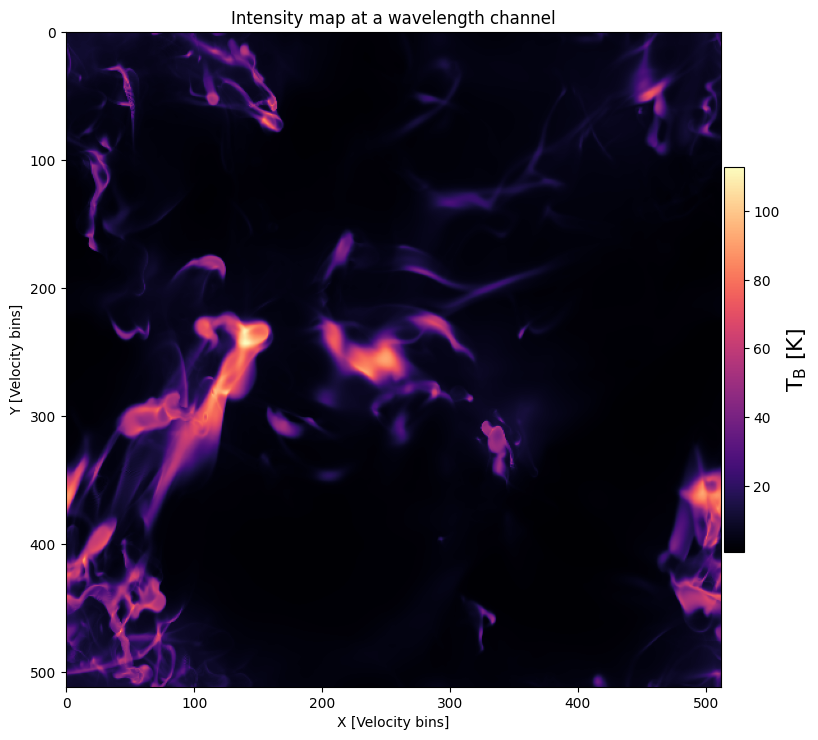

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(data[50, :, :], cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('T$_\mathrm{B}$ [K]', size=16)

plt.title('Intensity map at a wavelength channel')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

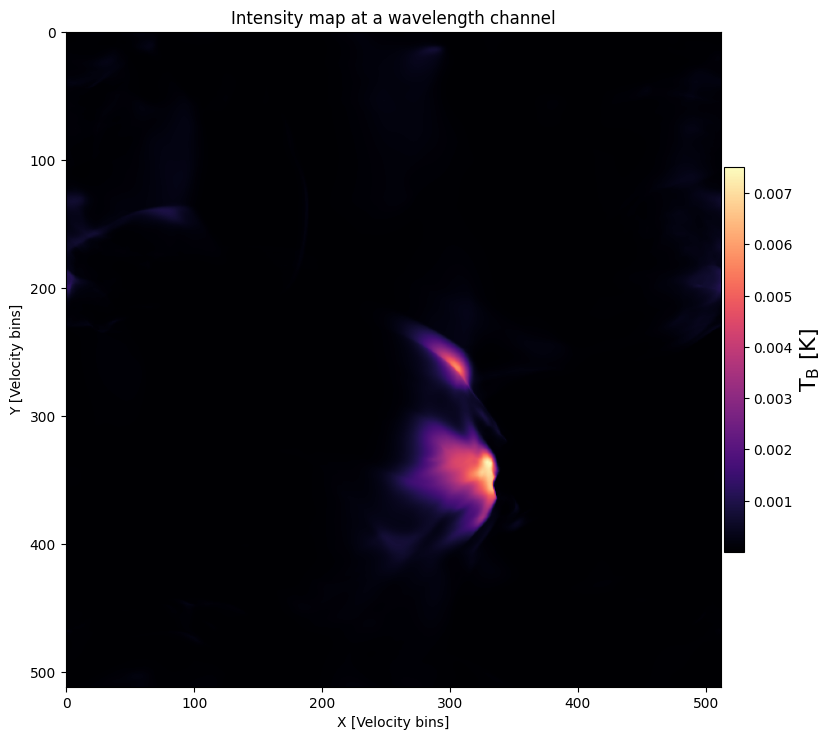

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(data[100, :, :], cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('T$_\mathrm{B}$ [K]', size=16)

plt.title('Intensity map at a wavelength channel')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

# Histogram of FCNM and R

**Note:** Atomic Hydrogen Gas = HI

In [28]:
FCNM = fcnm_data.ravel()
R    = rhi_data.ravel()

In [29]:
FCNM.shape

(262144,)

In [30]:
# stats_series = pd.DataFrame(FCNM).describe()
# series_index = stats_series.index.to_list()
# series_values = stats_series.values.flatten()
# print('FCNM:')
# stats_series

In [31]:
# stats_series = pd.DataFrame(R).describe()
# series_index = stats_series.index.to_list()
# series_values = stats_series.values.flatten()
# print('R:')
# stats_series

## Cold HI gas fraction: FCNM

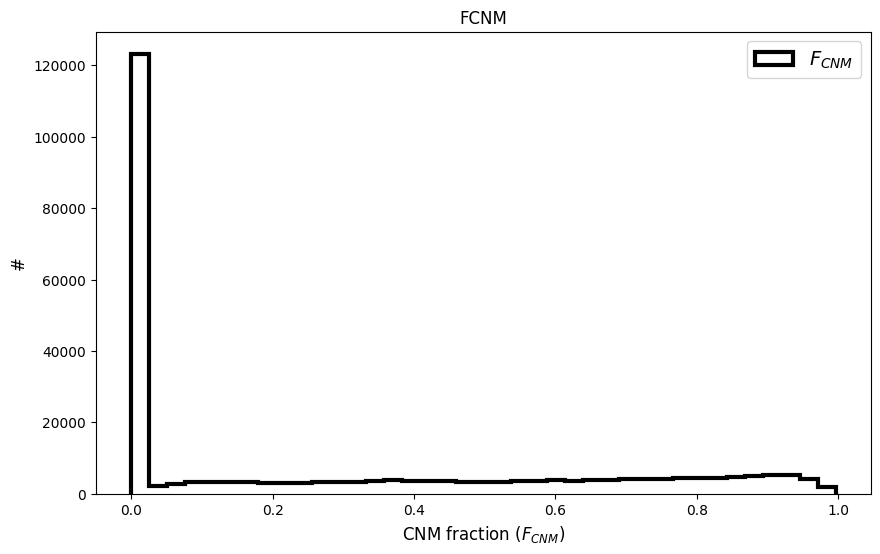

In [32]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(FCNM, bins=np.linspace(0., FCNM.max(), 40),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='$F_{CNM}$')

plt.title(f'FCNM')
plt.xlabel(r'CNM fraction ($F_{CNM}$)', fontsize=12)
plt.ylabel(r'#', fontsize=12)
# plt.yscale('log')

plt.legend(loc='upper right', fontsize=14)
plt.show()

## HI Opacity correction  Factor : R

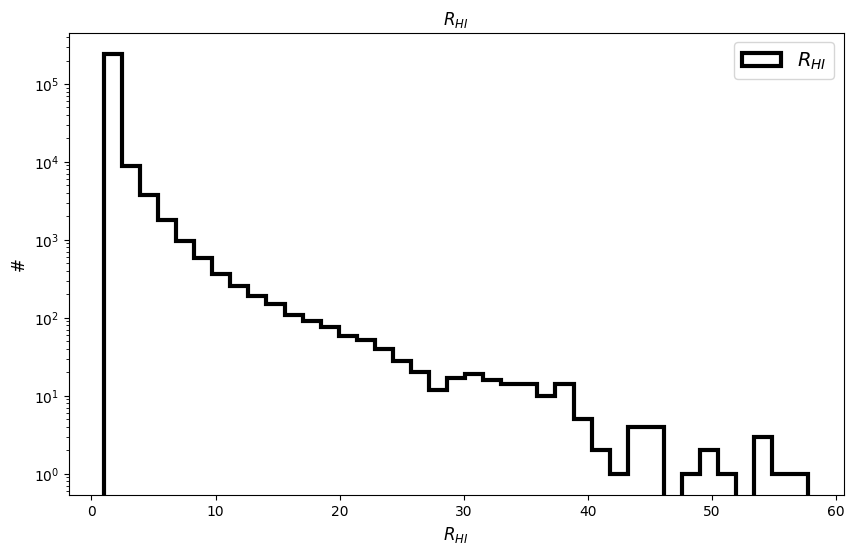

In [33]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(R, bins=np.linspace(1., R.max(), 40),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='$R_{HI}$')

plt.title('$R_{HI}$')
plt.xlabel(r'$R_{HI}$', fontsize=12)
plt.ylabel(r'#', fontsize=12)
plt.yscale('log')

plt.legend(loc='upper right', fontsize=14)
plt.show()

# Add noise to data cube

In [34]:
data, hdr = fits.getdata(training_data_fits_file, header=True)
print(data.shape)

(101, 512, 512)


In [35]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
NAXIS3  =                  101                                                  
EXTEND  =                    T                                                  
CTYPE3  = 'v [km.s-1]'                                                          
CRVAL3  =   -8.000000000000114                                                  
CDELT3  =                  0.8                                                  
CRPIX3  =                   40                                                  
BUNIT   = 'K       '                                                            
COMMENT Tb                  

In [36]:
data.shape

(101, 512, 512)

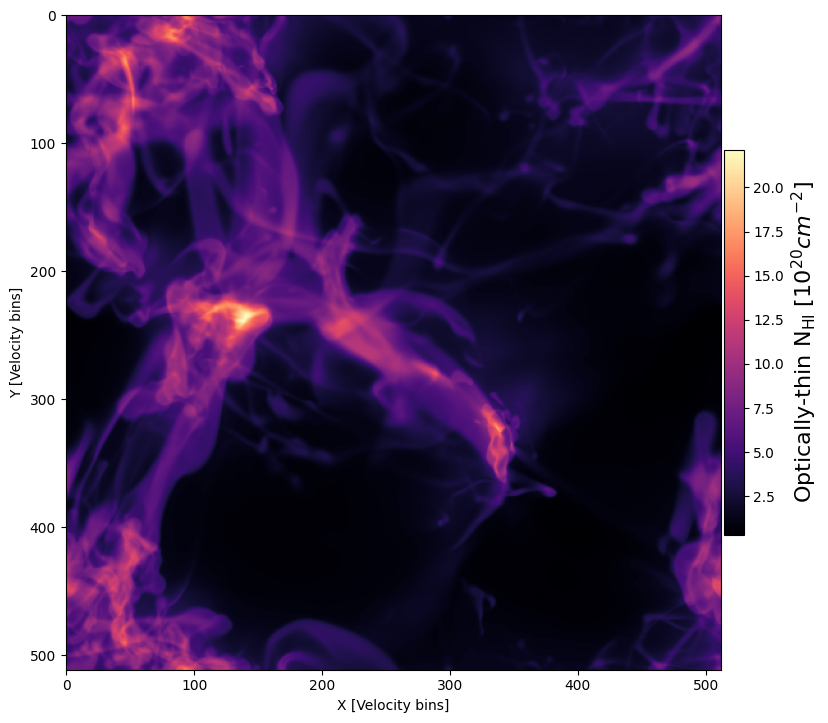

In [37]:
WHI = np.sum(data, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI * dv # In unit of 10^20 cm-2

plt.figure(figsize=(10,10))
plt.imshow(NHI_thin, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20} cm^{-2}$]', size=16)

plt.title('')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

In [38]:
#Noise level and beam size
noise = 1. #K
beam = 1.45 #pix ASKAP at 400pc with Saury resolution

In [39]:
from scipy import ndimage

# Convolution beam cube
smooth_cube = ndimage.gaussian_filter(data, [0,beam,beam])
smooth_cube.shape

(101, 512, 512)

In [40]:
nchan, ny, nx = smooth_cube.shape

In [41]:
# Add noise to the synthetic data cube
for i in range(nx):
  for j in range(ny):
    smooth_cube[:, j, i] += np.random.randn(nchan) * noise  

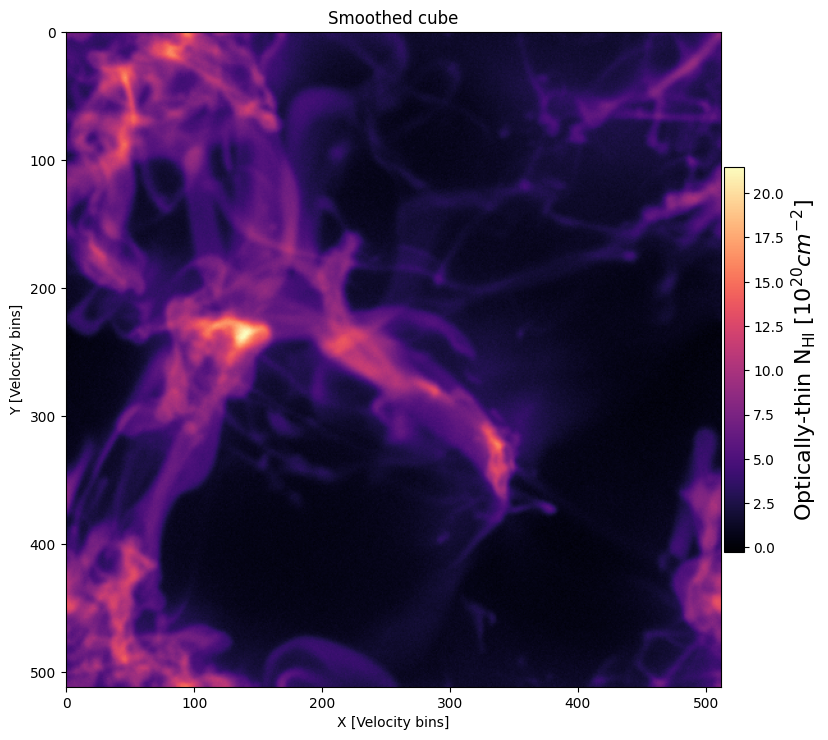

In [42]:
WHI = np.sum(smooth_cube, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI * dv # In unit of 10^20 cm-2

plt.figure(figsize=(10,10))
plt.imshow(NHI_thin, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20} cm^{-2}$]', size=16)

plt.title('Smoothed cube')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()

In [43]:
training_data_outfile = 'Tb_mpism_comp_1200_thick' + '_noise_' + str(noise) + '_K_beam_' + str(beam) + '_pix.fits'
training_data_fits_outfile = os.path.join(seta_data_path, training_data_outfile)
print(training_data_fits_outfile)

/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/seta/Tb_mpism_comp_1200_thick_noise_1.0_K_beam_1.45_pix.fits


In [44]:
hdu0 = fits.PrimaryHDU(smooth_cube, header=hdr)
hdulist = fits.HDUList([hdu0])
hdulist.writeto(training_data_fits_file , overwrite=True)

# Read the data cube with noise

In [45]:
data, hdr = fits.getdata(training_data_fits_outfile, header=True)
print(data.shape)

(101, 512, 512)


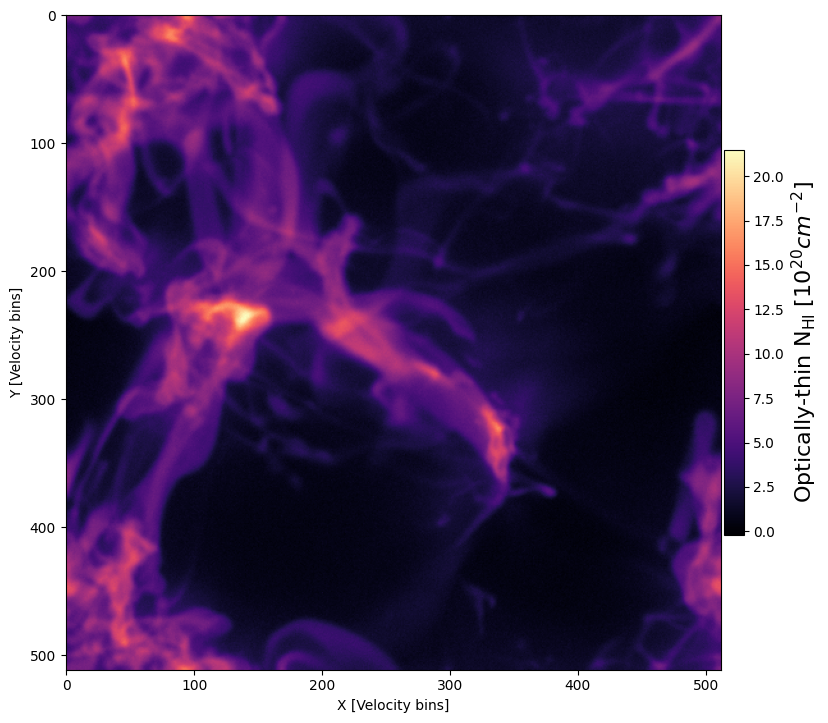

In [46]:
WHI = np.sum(data, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI * dv # In unit of 10^20 cm-2

plt.figure(figsize=(10,10))
plt.imshow(NHI_thin, cmap='magma')

cbar = plt.colorbar(shrink=0.5, pad=0.005)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20} cm^{-2}$]', size=16)

plt.title('')
plt.xlabel('X [Velocity bins]')
plt.ylabel('Y [Velocity bins]')
plt.show()